# Data Collection Lab - Final Project

In [0]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sparknlp.annotator import BertSentenceEmbeddings
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
from sparknlp.base import DocumentAssembler
from pyspark.sql import functions as F
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from scipy.spatial import distance
from pyspark.ml import Pipeline
from pyspark.sql.types import *
import seaborn as sns
import pandas as pd
import numpy as np
import pyspark
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

spark = SparkSession.builder.getOrCreate()

In [0]:
profiles = spark.read.parquet('/linkedin/people')

## Extracting the Label Column

### Exploration

We would like to take a look at the job titles of people in the 'profiles' dataset. In order to do that, let us display the 'position' attribute of each record:

In [0]:
profiles.select("position").limit(50).display()

position
Special Services Director at Sunnyside Unified School District
Retired at N/A
--
Military Pay Technician at DEFENSE FINANCE AND ACCOUNTING SERVICE-CLEVELAND Retired Annuitant Pay Cleveland Ohio
Senior Underwriter at Tokio Marine Insurance
--
--
--
Traffic control supervisor/T.C.L. Union member 242 Laborers union
Doctor of Occupational Therapy Student


From the 'position' values above, we can gather the two following insights:

1. For most of the records, the 'position' attribute is in the format of "{ job title } at { company name }". In addition, some are simply the job title itself, or the company name.

2. Many 'position' values are "--". These values do not reflect any information, and therefore we will identify them as missing values (along side nulls)

Thus, let us extract the job titles from the 'position' column:

In [0]:
def add_job_title(position):
    if position == "--" or position is None:
        return None
    
    position_lst = position.split(" at")
    job_title = str.lower(position_lst[0])

    return job_title

add_job_title_s = F.udf(add_job_title)

In [0]:
df_with_titles = profiles.select("position").withColumn("job_title", add_job_title_s(F.col("position")))
df_with_titles.limit(50).display()

position,job_title
Special Services Director at Sunnyside Unified School District,special services director
Retired at N/A,retired
--,null
Military Pay Technician at DEFENSE FINANCE AND ACCOUNTING SERVICE-CLEVELAND Retired Annuitant Pay Cleveland Ohio,military pay technician
Senior Underwriter at Tokio Marine Insurance,senior underwriter
--,null
--,null
--,null
Traffic control supervisor/T.C.L. Union member 242 Laborers union,traffic control supervisor/t.c.l. union member 242 laborers union
Doctor of Occupational Therapy Student,doctor of occupational therapy student


In [0]:
job_titles = df_with_titles.select("job_title")

Let us display below the missingness rate in the 'job_title' column:

In [0]:
total_num = job_titles.count()
non_missing_num = job_titles.dropna().count()

print(f"Total number of records in the dataset: {total_num}")
print(f"Number of records with missing job titles: {total_num - non_missing_num}")

print(f"Missingness rate: {round((100*(total_num - non_missing_num))/total_num, 3)}%")

Total number of records in the dataset: 3462290
Number of records with missing job titles: 918214
Missingness rate: 26.52%


As we can see, the missingness rate is not negligible. However, most of the values are not missing. Therefore, we can remove them and still have enough remaining records.

As a result, let us remove the missing values (null and "--" values):

In [0]:
job_titles = job_titles.dropna()

Now, let us display the number of unique job titles, and the frequency of each one:

In [0]:
job_title_counts = job_titles.groupBy("job_title").count().orderBy(F.desc(F.col("count")))

In [0]:
print(f"The dataset contains {job_title_counts.count()} unique job titles.")

The dataset contains 963422 unique job titles.


In [0]:
job_title_counts.limit(100).display()

job_title,count
student,105345
owner,42564
retired,40893
teacher,23715
president,21928
manager,15124
registered nurse,9829
office manager,9814
project manager,9719
administrative assistant,9196


### Reducing the Number of Job Titles

As we can see, there is an extremely large number of unique job titles (~1 million). However, the job title frequencies decay very quickly. For example, the 5th most common job title (president) appears ~20k times in the dataset, while the 20th most common job title (vice president) appears only ~5k times in the dataset, and the 100th most common job title (LPN) appears only ~1.5k times in the dataset.

As a result, in order to greatly reduce the variance of job titles, we will filter the data and keep only users with job titles of frequency higher than some threshold. We will choose this threshold by using an elbow graph, which will help us find the “sweet spot” (significantly reduce the number of job titles, without removing too many records from our dataset). 

In [0]:
job_titles_total = job_title_counts.count()
records_total = job_titles.count()
thresh_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

prcnt_records_removed_lst, prcnt_job_titles_removed_lst = [], []
for thresh in thresh_values:
    job_titles_above_thresh = job_title_counts.filter(F.col("count") > thresh)
    records_above_thresh = job_titles_above_thresh.agg(F.sum("count")).collect()[0][0]

    prcnt_records_removed = 100*(1 - (records_above_thresh / records_total))
    prcnt_job_titles_removed = 100*(1 - (job_titles_above_thresh.count() / job_titles_total))

    prcnt_records_removed_lst.append(prcnt_records_removed)
    prcnt_job_titles_removed_lst.append(prcnt_job_titles_removed)

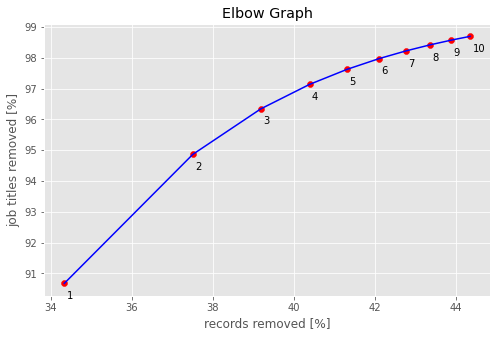

In [0]:
plt.style.use("ggplot")
plt.figure(figsize=(8, 5))
plt.plot(prcnt_records_removed_lst, prcnt_job_titles_removed_lst, c="blue")
plt.scatter(prcnt_records_removed_lst, prcnt_job_titles_removed_lst, c="red")
plt.title("Elbow Graph")
plt.xlabel("records removed [%]")
plt.ylabel("job titles removed [%]")

for x, y, thresh in zip(prcnt_records_removed_lst, prcnt_job_titles_removed_lst, thresh_values):
    plt.annotate(thresh, xy=(x, y), xytext=(x+0.06, y - 0.5))

As we can see, the higher thresholds should better be avoided (losing too many data records, without a justified increase to the number of job titles removed), but there is no specific point where the trade off clearly seems to be optimal. Thus, we will choose threshold 3, which seems to be in the middle point of the tradeoff. 

Note that by using this threshold, we manage to keep over 60% of the data, while reducing the number of distinct job titles by over 95%.

Let us create the following dataframe with the job titles that meet the said threshold:

In [0]:
filtered_job_titles = job_title_counts.filter(F.col("count") > 3)
filtered_job_titles.limit(100).display()

job_title,count
student,105345
owner,42564
retired,40893
teacher,23715
president,21928
manager,15124
registered nurse,9829
office manager,9814
project manager,9719
administrative assistant,9196


After filtering the job titles, we will use the remaining ones to extract the relevant users:

In [0]:
filtered_job_titles_unique_lst = filtered_job_titles.select("job_title").collect()
filtered_job_titles_unique_lst = [row["job_title"] for row in filtered_job_titles_unique_lst]

users = profiles.withColumn("job_title", add_job_title_s(F.col("position")))
users = users.filter(users.job_title.isin(filtered_job_titles_unique_lst))

users.limit(50).display()

about,avatar,certifications,city,country_code,current_company,current_company:company_id,current_company:name,education,educations_details,experience,followers,following,groups,id,languages,name,people_also_viewed,position,posts,recommendations,recommendations_count,timestamp,url,volunteer_experience,сourses,job_title
null,https://static.licdn.com/aero-v1/sc/h/244xhbkr7g40x6bsu4gi6q4ry,List(),"Spring, Texas, United States",US,"List(null, N/A, null, N/A, Retired at N/A)",null,N/A,"List(List(Bachelor of Arts (BA), 1963, Elementary Education and Teaching, 1959 - 1963, 1959, Baylor University, https://www.linkedin.com/school/baylor-university/?trk=public_profile_school_profile-section-card_image-click))",Baylor University,"List(List(null, null, null, null, null, null, null, null, null, N/A, null, Retired, null))",13,13,List(),sharon-tunnell-436474104,List(),Sharon Tunnell,List(),Retired at N/A,List(),List(),null,2023-09-04,https://www.linkedin.com/in/sharon-tunnell-436474104,List(),List(),retired
hard worker goal oriented and willing to work,https://static.licdn.com/aero-v1/sc/h/244xhbkr7g40x6bsu4gi6q4ry,List(),"Cleveland, Ohio, United States",US,"List(dfas, DFAS, https://cn.linkedin.com/company/dfas?trk=public_profile_topcard-current-company, DFAS, Military Pay Technician at DEFENSE FINANCE AND ACCOUNTING SERVICE-CLEVELAND Retired Annuitant Pay Cleveland Ohio)",dfas,DFAS,"List(List(null, 2005, null, 2004 - 2005 Received training in radio and television broadcast and production techniques. Skilled in operation of various audio and video studio equipment. Hands-on experience with Cool-Edit audio workstation. Practice with copy and news writing skills. Have maintained perfect attendance., 2004, OHIO CENTER FOR BROADCASTING, null), List(Bachelor of General Studies, 1999, General Studies of Art & Science, 1994 - 1999 Activities: Kent Interhall Council, Channels 45/49 Public Television, TV2, and Black United Students., 1994, Kent State University, https://cn.linkedin.com/school/kent-state-university/?trk=public_profile_school_profile-section-card_image-click))",OHIO CENTER FOR BROADCASTING,"List(List(DFAS, dfas, null, 14 years 8 months, null, null, null, List(List(Responsible for handling retired military pay accounts and answering the phone from Members, Annuitant and former spouse., Feb 2009 - Present 14 years 8 months, 14 years 8 months, Present, Feb 2009 - Present14 years 8 months , Responsible for handling retired military pay accounts and answering the phone from Members, Annuitant and former spouse., Feb 2009, DFAS, Military Pay Technician), List(Responsible for handling retired military pay accounts and answering the phone from Members, Annuitant and former spouse., Feb 2009 - Present 14 years 8 months, 14 years 8 months, Present, Feb 2009 - Present14 years 8 months , Responsible for handling retired military pay accounts and answering the phone from Members, Annuitant and former spouse., Feb 2009, DEFENSE FINANCE AND ACCOUNTING SERVICE-CLEVELAND Retired Annuitant Pay Cleveland Ohio, Military Pay Technician)), null, null, null, null, https://cn.linkedin.com/company/dfas?trk=public_profile_experience-group-header), List(null, null, Responsible for handling retired military pay accounts and answering the phone from Members, Annuitant and former spouse. Responsible for handling retired military pay accounts and answering the phone from Members, Annuitant and former spouse., Jan 2003 Jan 2009 6 years 1 month, 6 years 1 month, Jan 2009, null, null, Jan 2003, LOCKHEED MARTIN-DFAS CLEVELAND, Retired Annuitant Pay, null, Military Pay Technician, null), List(null, null, Shoot video. Shoot video., 2009 2009 less than a year, less than a year, 2009, null, null, 2009, Sportview Technologies, null, Internship, null), List(null, null, Camera work for Thistledown for live horse races. Camera work for Thistledown for live horse races., Jan 2007 Sep 2007 9 months, 9 months, Sep 2007, null, null, Jan 2007, SPORTVIEW, null, Internship, null), Lis

In [0]:
print(f"Number of records: {users.count()}")
print(f"Number of distinct job titles: {filtered_job_titles.count()}")

Number of records: 1547087
Number of distinct job titles: 35259


### Assigning Job Titles to Groups Using an LLM (ChatGPT)

We managed to dramatically reduce the variance of the job title column (by over 95%). However, we still have over 30k distinct job titles. This will be unfeasible to work with.

Thus, we will use an LLM to cluster the job titles into the following 10 general groups:

- Management and Leadership

- Healthcare and Medical

- Education and Teaching

- Business and Administration

- Legal and Law

- Technology and Engineering

- Creative and Artistic

- Financial and Accounting

- Customer Service and Sales

- Nonprofit and Social Services

In addition, although our groups cover a broad range of job titles, some job titles may not belong in any of them. In order to prevent wrong group assignments, will define an additional group called "Miscellaneous", and instruct the LLM to assign all said values to this group. Moreover, we noticed that even the most common job titles still contain irrelevant and invalid values (e.g. "retired", ".", "n/a", etc.). This group will be relevant for these values as well.

Since we cannot import the OpenAI python library to Databricks, we ran the corresponding code on our personal computer. 

Let us read the dictionary we received as output:

In [0]:
# please change the path below, to where the 'job_titles_dict.txt' file is located in *your* environment
path = "Enter your path"

In [0]:
with open(path, "r", encoding='utf-8') as f:
    job_titles_dict_str = f.read()
    job_titles_dict = json.loads(job_titles_dict_str)

### Fixing the LLM Output

First, we would like to confirm that the LLM indeed assigned a group to each of our job titles.

In [0]:
missing_job_titles = filtered_job_titles.filter(~F.col("job_title").isin(list(job_titles_dict.keys())))

print(f"Number of missing job titles: {missing_job_titles.count()}")

Number of missing job titles: 90


As we can see, there are 90 job titles that the LLM did not assign a group to. 

Let us explore this phenomenon:

In [0]:
missing_job_titles.select("job_title").display()

job_title
n/a
...
1
…
entrepeneur
....
o
0wner
maintance
independant contractor


It appears that the vast majority of such missing job titles are spam and invalid values. However, some seem to be valid job titles (with minor typos). We would like to assign a group to such valid job titles manually, as well as assign invalid job titles to group "Miscellaneous".

In [0]:
job_titles_dict["0wner"] = "Management and Leadership"
job_titles_dict["medical assitant"] = "Healthcare and Medical"
job_titles_dict["administrative assisstant"] = "Business and Administration"
job_titles_dict["physican"] = "Healthcare and Medical"
job_titles_dict["assisstant manager"] = "Management and Leadership"
job_titles_dict["assitant professor"] = "Education and Teaching"
job_titles_dict["physican assistant"] = "Healthcare and Medical"
job_titles_dict["sales consulant"] = "Customer Service and Sales"
job_titles_dict["medical assisant"] = "Healthcare and Medical"
job_titles_dict["project mananger"] = "Management and Leadership"

In [0]:
# adding problematic job titles to group "Miscellaneous"
missing_job_titles_rows = missing_job_titles.collect()
for row in missing_job_titles_rows:
  jt = row["job_title"]

  if jt not in job_titles_dict:
    job_titles_dict[jt] = "Miscellaneous"

Second, we would like to confirm that the LLM indeed assigned each job title a group among the 11 "real" groups that we provided.

In [0]:
real_groups = ["Management and Leadership", "Healthcare and Medical", "Education and Teaching", "Business and Administration", "Legal and Law", "Technology and Engineering", "Creative and Artistic", "Financial and Accounting", "Customer Service and Sales", "Nonprofit and Social Services", "Miscellaneous"]

Let us display all "fake" groups (not among the 11 "real" groups) that the LLM assigned, as well as how frequent those assignments are.

In [0]:
def show_fake_groups(print_counts=False):
    fake_groups = []
    for jt, assigned_group in job_titles_dict.items():
        if assigned_group not in real_groups:
            fake_groups.append(assigned_group)

    if print_counts:
        print(f"{len(fake_groups)} job titles are assigned to {len(set(fake_groups))} fake groups!\n")

    fake_groups_dict = {}
    for fg in fake_groups:
        if fg not in fake_groups_dict:
            fake_groups_dict[fg] = 1
        else:
            fake_groups_dict[fg] += 1

    tups = [(k, v) for k, v in fake_groups_dict.items()]
    sorted_tups = sorted(tups, key=lambda x: x[1], reverse=True)

    if print_counts:
        for tup in sorted_tups:
            print(f"{tup[0]}: {tup[1]}")
    
    fake_groups_distinct = set(list(fake_groups_dict.keys()))
    return fake_groups_distinct


In [0]:
fake_groups = show_fake_groups(print_counts=True)

1293 job titles are assigned to 212 fake groups!

6: 58
11: 54
Hospitality and Culinary: 50
1: 44
Government and Public Administration: 37
Science and Research: 35
4: 35
2: 34
Human Resources: 33
8: 33
11. Miscellaneous: 31
Sports and Recreation: 30
6. Technology and Engineering: 29
4. Business and Administration: 28
9: 27
Hospitality and Tourism: 26
3: 25
Military and Defense: 22
7: 22
2. Healthcare and Medical: 19
Marketing and Advertising: 18
10: 17
Construction and Engineering: 17
Manufacturing and Production: 16
Construction and Architecture: 16
9. Customer Service and Sales: 16
Hospitality and Food Service: 14
Government and Public Service: 14
Real Estate: 14
8. Financial and Accounting: 12
Government and Military: 11
Human Resources and Recruitment: 11
7. Creative and Artistic: 11
Construction and Maintenance: 11
1. Management and Leadership: 10
Human Resources and Administration: 10
Real Estate and Property Management: 9
10. Nonprofit and Social Services: 9
Business and Adminst

As we can see, there are two main problems with the LLM's assignments:
1. The LLM assigned the "real" groups, but in different name variations (e.g. the number of the group instead of its name).

2. The LLM assigned "fake" groups, that are not among the "real" groups.

We will deal with the first problem by renaming the different variations of the "real" groups to their original name, and reassigning the job titles into the correct group.

In [0]:
# assign job titles in fake groups, to the fixed groups

fixed_groups = {
    1: "Management and Leadership",
    2: "Healthcare and Medical",
    3: "Education and Teaching",
    4: "Business and Administration",
    5: "Legal and Law",
    6: "Technology and Engineering",
    7: "Creative and Artistic",
    8: "Financial and Accounting",
    9: "Customer Service and Sales",
    10: "Nonprofit and Social Services",
    11: "Miscellaneous",
    "1. Management and Leadership": "Management and Leadership",
    "2. Healthcare and Medical": "Healthcare and Medical",
    "3. Education and Teaching": "Education and Teaching",
    "4. Business and Administration": "Business and Administration",
    "5. Legal and Law": "Legal and Law",
    "6. Technology and Engineering": "Technology and Engineering",
    "7. Creative and Artistic": "Creative and Artistic",
    "8. Financial and Accounting": "Financial and Accounting",
    "9. Customer Service and Sales": "Customer Service and Sales",
    "10. Nonprofit and Social Services": "Nonprofit and Social Services",
    "11. Miscellaneous": "Miscellaneous"
}

# reassign job titles
dict_items = list(job_titles_dict.items())
for jt, assigned_group in dict_items:
    if assigned_group in fixed_groups:
        job_titles_dict[jt] = fixed_groups[assigned_group]

Now, let us display the "fake" groups remaining:

In [0]:
remaining_fake_groups = show_fake_groups(print_counts=True)

762 job titles are assigned to 190 fake groups!

Hospitality and Culinary: 50
Government and Public Administration: 37
Science and Research: 35
Human Resources: 33
Sports and Recreation: 30
Hospitality and Tourism: 26
Military and Defense: 22
Marketing and Advertising: 18
Construction and Engineering: 17
Manufacturing and Production: 16
Construction and Architecture: 16
Hospitality and Food Service: 14
Government and Public Service: 14
Real Estate: 14
Government and Military: 11
Human Resources and Recruitment: 11
Construction and Maintenance: 11
Human Resources and Administration: 10
Real Estate and Property Management: 9
Business and Adminstration: 9
Real Estate and Property: 8
Construction and Skilled Trades: 8
Hospitality and Event Planning: 8
Sports and Fitness: 8
Sports and Athletics: 8
Science and Engineering: 8
Sales and Customer Service: 8
Construction and Trades: 7
Marketing and Public Relations: 7
Transportation and Logistics: 7
Government and Law: 6
Religious and Spiritual:

From the above exploration, we can derive the following insights:

1. The number of fake groups is 190, and therefore cannot be assigned manually.

2. The vast majority of the fake groups contain only a single job title, and the largest fake group contains only 50 job titles. Therefore, they do not cover a high enough number of job titles to justify adding them as "real" groups.

Thus, we would like to reassign the job titles under these groups to group "Miscellaneous". However, this will result in removing the corresponding records later on. Therefore, let us check the percentage of records in those groups within our dataset:

In [0]:
def add_group(job_title, job_titles_dict):
    if job_title in job_titles_dict:
        return job_titles_dict[job_title]

def add_group_s(job_titles_dict):
    return F.udf(lambda x: add_group(x, job_titles_dict), StringType())

In [0]:
job_titles_with_groups = users.select("job_title").withColumn("group", add_group_s(job_titles_dict)(F.col("job_title")))
job_titles_with_fake_groups = job_titles_with_groups.filter(~F.col("group").isin(real_groups))

prcnt = job_titles_with_fake_groups.count() / users.count()
print(f'Percentage of records assigned to "fake" groups: {prcnt*100:.3f}%')

Percentage of records assigned to "fake" groups: 0.995%


As we can see, the records in those groups consist of less than 1% of our data. Hence, we can confidently reassign them to group "Miscellaneous".

In [0]:
# assign job titles that were assigned to the remaining fake groups, to "Miscellaneous"
dict_items = list(job_titles_dict.items())
for jt, assigned_group in dict_items:    
    if assigned_group not in real_groups:
        job_titles_dict[jt] = "Miscellaneous"

Finally, let us create the labelled dataset that we will move forward with:

In [0]:
# assign group to each record
users = users.withColumn("group", add_group_s(job_titles_dict)(F.col("job_title")))

# remove records assigned to group Miscellaneous
users = users.filter(F.col("group") != "Miscellaneous")

In [0]:
print(f"The final number of records in our dataset: {users.count()}")

The final number of records in our dataset: 1390751


Now that we have the dataset of users that we will proceed with, let us explore the data by displaying the distribution of groups that users are assigned to:

In [0]:
group_counts_rows = users.groupBy("group").count().orderBy(F.asc(F.col("count"))).collect()

groups, counts = [], []
for row in group_counts_rows:
    groups.append(row["group"])
    counts.append(row["count"])

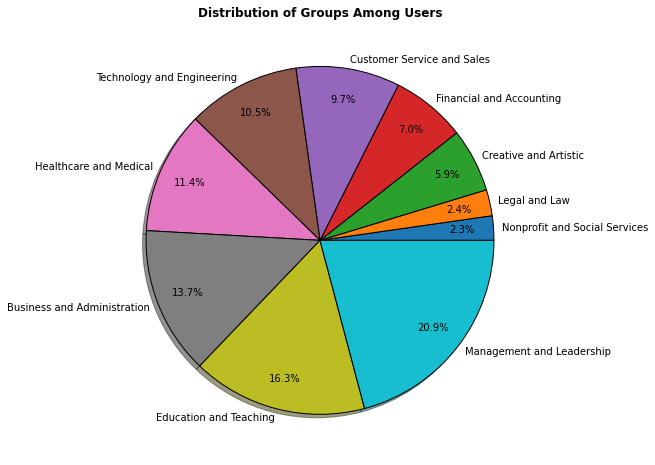

In [0]:
plt.figure(figsize=(11, 8))
plt.rcdefaults()
plt.pie(counts, labels=groups, autopct='%1.1f%%', wedgeprops={'edgecolor':'black'}, startangle=0,
        shadow=True, pctdistance=0.82, labeldistance=1.05)
plt.title("Distribution of Groups Among Users", fontweight="bold")
plt.show()

From the graph above, we can see the following:

- The distribution of the groups is not uniform, resulting in quite imbalanced labels.

- The most common group across users in our dataset is "Management and Leadership" (about 20% of our data).

- The least common groups across users in our dataset are "Nonprofit and Social Services" and "Legal and Law" (about 2.5% of our data each).

## **Extracting Features**

In this section, we will extract the following features from our dataset (that we will use later on as the input of our model):


From the **Education** column, we will extract the following features:

- Number of degrees

- Highest degree type

- Accumulated number of education years

- Field cosine similarities


From the **Experience** column, we will extract the following features:

- Number of past jobs

- Accumulated number of experience years


From the **other** columns, we will extract the following features:

- Number of recommendations

- Number of certifications

- Number of spoken languages

- Number of volunteerings

- Number of courses

- 'About' section embeddings

In [0]:
### education columns

def add_num_degrees(education):
    if education is None:
        return 0
    return len(education)

def add_highest_degree(education):
    if education is None or len(education) == 0:
        return 0
    
    highest_degree = 1
    for item in education:
        if item.degree is None:
            continue

        degree = str.lower(item.degree).replace(".", "")
        
        if "bachelor" in degree or "bs" in degree:
            highest_degree = max(highest_degree, 2)
        
        if "master" in degree or "ms" in degree:
            highest_degree = max(highest_degree, 3)
        
        if "phd" in degree or "doctor" in degree:
            highest_degree = max(highest_degree, 4)
            break
    
    return highest_degree

def add_edu_years(education):
    if education is None or len(education) == 0:
        return 0
    
    accumulated_edu_years = 0
    for item in education:
        if item.start_year is not None and item.end_year is not None:
            accumulated_edu_years += (int(item.end_year) - int(item.start_year) + 1)
    
    return accumulated_edu_years

def add_edu_field_indicator(education):
    if education is None or len(education) == 0:
        return 1
    
    for item in education:
        field = item.field

        if field is not None:
            return 0
    
    return 1


add_num_degrees_s = F.udf(add_num_degrees, IntegerType())
add_highest_degree_s = F.udf(add_highest_degree, IntegerType())
add_edu_years_s = F.udf(add_edu_years, IntegerType())
add_edu_field_indicator_s = F.udf(add_edu_field_indicator, IntegerType())

In [0]:
### experience columns

def add_num_jobs(experience):
    if experience is None:
        return 0
    return len(experience)

def calc_company_months(duration_short):
    if duration_short == "less than a year":
        return 6
    
    duration_short = duration_short.split(" ")

    # the foramt is "x years y months"
    if len(duration_short) == 4:
        company_months = (int(duration_short[0]) * 12) + int(duration_short[2])

    # the format is "x year/years"
    elif "year" in duration_short[1]:
        company_months = int(duration_short[0]) * 12

    # the format is "y month/months"
    else:
        company_months = int(duration_short[0])

    return company_months

def add_exp_years(experience):
    if experience is None or len(experience) == 0:
        return 0.0
    
    accumulated_exp_months = 0.0
    for item in experience:
        if item.duration_short is not None:
            accumulated_exp_months += float(calc_company_months(item.duration_short))
    
    accumulated_exp_years = accumulated_exp_months / 12.0
    return accumulated_exp_years


add_num_jobs_s = F.udf(add_num_jobs, IntegerType())
add_exp_years_s = F.udf(add_exp_years, FloatType())

In [0]:
### other columns

def add_num_certifications(certifications):
    if certifications is None:
        return 0
    return len(certifications)

def add_num_languages(languages):
    if languages is None or len(languages) == 0:
        return 1
    return len(languages)

def add_num_volunteers(volunteer_experience):
    if volunteer_experience is None:
        return 0
    return len(volunteer_experience)

def add_num_courses(courses):
    if courses is None:
        return 0
    return len(courses)

def add_label(group):
    group_to_label = {
        'Management and Leadership': 0,
        'Healthcare and Medical': 1, 
        'Education and Teaching': 2,
        'Business and Administration': 3,
        'Legal and Law': 4,
        'Technology and Engineering': 5,
        'Creative and Artistic': 6, 
        'Financial and Accounting': 7,
        'Customer Service and Sales': 8,
        'Nonprofit and Social Services': 9
        }
    
    return group_to_label[group]


add_num_certifications_s = F.udf(add_num_certifications, IntegerType())
add_num_languages_s = F.udf(add_num_languages, IntegerType())
add_num_volunteers_s = F.udf(add_num_volunteers, IntegerType())
add_num_courses_s = F.udf(add_num_courses, IntegerType())
add_label_s = F.udf(add_label, IntegerType())

array_to_vector_s = F.udf(lambda arr: Vectors.dense(arr), VectorUDT())

In [0]:
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("sentence")

embeddings = BertSentenceEmbeddings.pretrained("sent_small_bert_L2_128") \
    .setInputCols(["sentence"]) \
    .setOutputCol("embeddings")\
    .setCaseSensitive(True) \
    .setMaxSentenceLength(512)
    
bert_pipeline = Pipeline(stages=[documentAssembler,
                            embeddings])

sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]


In [0]:
def embed_column(df, col_name, pipeline):

    new_df = df.withColumnRenamed(col_name, "text")
    model = pipeline.fit(new_df)
    results_df = model.transform(new_df)

    embedded_column_df = results_df.select(F.col("index"),
                                           F.explode(results_df.embeddings.embeddings)\
                                                    .alias(f"{col_name}_embedding"))
  
    return embedded_column_df

def explode_column(df, main_col_name, sub_col_name):
    rdd = df.select("index", main_col_name).rdd

    rdd = rdd.flatMap(lambda row: [(row[0], item[sub_col_name]) for item in row[1]])

    rdd = rdd.filter(lambda row: row[1] is not None)

    schema = StructType([StructField("index", StringType(), True), StructField(sub_col_name, StringType(), True)])
    exploded_df = spark.createDataFrame(rdd, schema=schema)

    return exploded_df

def calc_cosine_similarity(v1, v2):
  return float(distance.cosine(v1, v2))

def calc_cosine_similarity_default_vec(default_vec):
    return F.udf(lambda x: calc_cosine_similarity(x, default_vec), FloatType())

def get_column_cosine_similarity(df, pipeline, group_names_embeddings, col_name): 

    new_df = df.select("index", col_name)

    # embed
    embedded_df = embed_column(new_df, col_name, pipeline)

    new_cols_names = []
    # calculate the cosine similarities
    for (group_name, group_vec) in group_names_embeddings:
        new_col_name = f"{col_name}-{group_name}_cs"
        embedded_df = embedded_df.withColumn(f"{new_col_name}",
                                            calc_cosine_similarity_default_vec(group_vec)
                                            (F.col(f"{col_name}_embedding")))

        new_cols_names.append(new_col_name)

    # calcualte the max cosine similarities across the field values
    grouped_df = embedded_df.groupBy("index")
    cs_df = grouped_df.agg(*[(F.max(col).alias(col)) for col in new_cols_names])

    return cs_df.select(["index"] + new_cols_names)

def get_group_embeddings(df, pipeline):
    unique_group_df = df.select("group").dropDuplicates()\
                                .withColumnRenamed("group", "text")

    model = pipeline.fit(unique_group_df)
    result_df = model.transform(unique_group_df)

    result_df = result_df.select(F.explode(F.arrays_zip
                            (result_df.sentence.result, 
                            result_df.embeddings.embeddings)).alias("cols")) \
                    .select(F.expr("cols['0']").alias("group_name"),
                            F.expr("cols['1']").alias("embeddings"))
                    
    result_lst = result_df.collect()

    group_embeddings = []
    for row in result_lst:
        group_embeddings.append((row["group_name"], row["embeddings"]))
    
    return group_embeddings

def process_field_empty(field_empty, group_names_embeddings):
    new_col_names = ["index"]
    for group_name, _ in group_names_embeddings:
        new_col_name = f"field-{group_name}_cs"
        field_empty = field_empty.withColumn(new_col_name, F.lit(0))
        new_col_names.append(new_col_name)

    return field_empty.select(new_col_names)

def process_field_not_empty(field_not_empty, group_names_embeddings, pipeline):
    exploded_df = explode_column(field_not_empty, "education", "field")

    cs_df = get_column_cosine_similarity(exploded_df, pipeline, group_names_embeddings, "field")
    return cs_df

def add_field_features(df, pipeline):
    new_df = df.select("index", "education")

    new_df = new_df.withColumn("edu_field_indicator", add_edu_field_indicator_s(F.col("education")))

    field_empty = new_df.filter(F.col("edu_field_indicator") == 1)
    field_not_empty = new_df.filter(F.col("edu_field_indicator") == 0)

    group_names_embeddings = get_group_embeddings(df, pipeline)

    field_empty = process_field_empty(field_empty, group_names_embeddings)
    field_not_empty = process_field_not_empty(field_not_empty, group_names_embeddings, pipeline)

    full_df = field_empty.union(field_not_empty)
    full_df = full_df.withColumnRenamed("index", "field_index")

    return full_df

In [0]:
def calc_cosine_similarity(v1, v2):
  return float(distance.cosine(v1, v2))

def calc_cosine_similarity_default_vec(default_vec):
    return F.udf(lambda x: calc_cosine_similarity(x, default_vec), FloatType())

def embed_column(df, pipeline, col_name):
    current_cols = df.drop(col_name).columns

    new_df = df.withColumnRenamed(col_name, "text")
    model = pipeline.fit(new_df)
    results_df = model.transform(new_df)

    embedded_column_df = results_df.select(current_cols + [F.explode(results_df.embeddings.embeddings)\
                                                                 .alias(f"{col_name}_embedding")])
    return embedded_column_df

def get_group_embeddings(df, pipeline):
    unique_group_df = df.select("group").dropDuplicates()\
                                .withColumnRenamed("group", "text")

    model = pipeline.fit(unique_group_df)
    result_df = model.transform(unique_group_df)

    result_df = result_df.select(F.explode(F.arrays_zip
                            (result_df.sentence.result, 
                            result_df.embeddings.embeddings)).alias("cols")) \
                    .select(F.expr("cols['0']").alias("group_name"),
                            F.expr("cols['1']").alias("embeddings"))
                    
    result_lst = result_df.collect()

    group_embeddings = []
    for row in result_lst:
        group_embeddings.append((row["group_name"], row["embeddings"]))
    
    return group_embeddings

def get_column_cosine_similarity(df, pipeline, col_name, group_names_embeddings): 
    # get current columns without 'col_name'
    current_cols = df.drop(col_name).columns

    # embed 'col_name' column
    embedded_df = embed_column(df, pipeline, col_name)

    new_cols = []
    # calculate the cosine similarities
    for (group_name, group_vec) in group_names_embeddings:
        new_col = f"{col_name}-{group_name}_cs"
        embedded_df = embedded_df.withColumn(f"{new_col}",
                                            calc_cosine_similarity_default_vec(group_vec)
                                            (F.col(f"{col_name}_embedding")))

        new_cols.append(new_col)

    # calcualte the max cosine similarities across the field values
    grouped_df = embedded_df.groupBy(current_cols)
    cs_df = grouped_df.agg(*[(F.max(col).alias(col)) for col in new_cols])

    return cs_df.select(current_cols + new_cols)

def explode_column(df, main_col_name, sub_col_name):
    
    exploded_df = df.withColumn(f"exploded_{main_col_name}", F.explode(F.col(main_col_name)))\
                    .withColumn(sub_col_name, F.col(f"exploded_{main_col_name}")[sub_col_name])\
                    .drop(f"exploded_{main_col_name}")

    return exploded_df

def process_field_empty(field_empty, group_names_embeddings):
    current_cols = field_empty.columns
    new_cols = []

    for group_name, _ in group_names_embeddings:
        new_col = f"field-{group_name}_cs"
        field_empty = field_empty.withColumn(new_col, F.lit(0))
        new_cols.append(new_col)

    return field_empty.select(current_cols + new_cols)

def process_field_not_empty(field_not_empty, pipeline, group_names_embeddings):
    # explode the education column to extract all field attributes (for each user)
    exploded_df = explode_column(field_not_empty, "education", "field")

    # calcualte the cs attributes (between the user's fields and the group names)
    cs_field_df = get_column_cosine_similarity(exploded_df, pipeline, "field", group_names_embeddings)
    return cs_field_df

def add_field_features(df, pipeline):

    # split the df into two:
    # users with all empty fields attributes
    # users with at least one non-empty field attribute
    new_df = df.withColumn("edu_field_indicator", add_edu_field_indicator_s(F.col("education")))
    field_empty = new_df.filter(F.col("edu_field_indicator") == 1)
    field_not_empty = new_df.filter(F.col("edu_field_indicator") == 0)

    # get the embedding of the group names
    group_names_embeddings = get_group_embeddings(df, pipeline)

    # process each of the dfs
    field_empty = process_field_empty(field_empty, group_names_embeddings)
    field_not_empty = process_field_not_empty(field_not_empty, pipeline, group_names_embeddings)


    # union the dfs back together
    full_df = field_empty.union(field_not_empty)

    return full_df.drop("edu_field_indicator")

In [0]:
def get_dataset(df, pipeline):
    ### select relevant columns
    relevant_cols = ["about", "certifications", "education", "experience", "languages",              
                     "recommendations_count", "volunteer_experience", "сourses", "group"]
    
    dataset = df.select(relevant_cols)

    ### add feature columns

    # add education field features
    dataset = add_field_features(dataset, pipeline)

    # add 'about' embeddings
    dataset = embed_column(dataset, pipeline, "about")
    dataset = dataset.withColumn("about_embedding", array_to_vector_s(F.col("about_embedding")))
    
    # add number of degrees
    dataset = dataset.withColumn("num_degrees", add_num_degrees_s(F.col("education")))

    # add highest degree type
    dataset = dataset.withColumn("highest_degree", add_highest_degree_s(F.col("education")))

    # add accumulated number of education years
    dataset = dataset.withColumn("edu_years", add_edu_years_s(F.col("education")))

    # add number of past jobs
    dataset = dataset.withColumn("num_jobs", add_num_jobs_s(F.col("experience")))

    # add accumulated number of experience years
    dataset = dataset.withColumn("exp_years", add_exp_years_s(F.col("experience")))
    
    # add recommendations count
    dataset = dataset.fillna({"recommendations_count": 0})

    # add number of certifications
    dataset = dataset.withColumn("num_certifications", add_num_certifications_s(F.col("certifications")))

    # add number of languages spoken
    dataset = dataset.withColumn("num_languages", add_num_languages_s(F.col("languages")))

    # add number of volunteerings
    dataset = dataset.withColumn("num_volunteers", add_num_volunteers_s(F.col("volunteer_experience")))

    # add number of courses taken
    dataset = dataset.withColumn("num_courses", add_num_courses_s(F.col("сourses")))


    # add label
    dataset = dataset.withColumn("label", add_label_s(F.col("group")))

    # remove unnecessary columns
    dataset = dataset.drop("index", "about", "certifications", "education", "experience", "languages", "volunteer_experience", "сourses", "group")

    return dataset

## Model

In this section we would like to find the model which suits our task the best. Therefore, we will conduct numerous tests which will help us find it.

Since our data contains an extremely large number of records (~1.4 million), we will perform said tests on 25% of it. This will allow us to save valuable computational time, and thus perform as many tests as possible (given the time limit).

Let us create the sampled dataset:

In [0]:
# sample 25% of our data
sampled_users = users.sample(withReplacement=False, fraction=0.25, seed=42)

# create the dataset
sampled_dataset = get_dataset(sampled_users, bert_pipeline)

In [0]:
sampled_dataset.limit(50).display()

recommendations_count,field-Creative and Artistic_cs,field-Management and Leadership_cs,field-Nonprofit and Social Services_cs,field-Customer Service and Sales_cs,field-Healthcare and Medical_cs,field-Legal and Law_cs,field-Education and Teaching_cs,field-Technology and Engineering_cs,field-Financial and Accounting_cs,field-Business and Administration_cs,about_embedding,num_degrees,highest_degree,edu_years,num_jobs,exp_years,num_certifications,num_languages,num_volunteers,num_courses,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Map(length -> 128, values -> List(-1.5937150716781616, 1.2038421630859375, -1.971187949180603, -1.5596635341644287, -0.7232573628425598, 0.2680276036262512, 0.5049799680709839, 0.437225878238678, -0.5181710124015808, 1.5076898336410522, 0.46652424335479736, -0.48301124572753906, -3.5078108310699463, 0.2540515661239624, 1.853528380393982, -1.2740867137908936, -0.6869056820869446, -0.2774699926376343, -1.9827078580856323, 0.6841188073158264, -0.32075387239456177, -0.4517170190811157, 2.592238426208496, 1.0330734252929688, 0.3717060685157776, 0.17448770999908447, 0.1374662220478058, 0.6337615847587585, 0.32424110174179077, 0.19708502292633057, -1.7193061113357544, -0.6912002563476562, -0.39116621017456055, 0.5239559412002563, 1.527153730392456, -1.4057199954986572, 0.3157801032066345, -0.8044559955596924, -1.6571323871612549, -1.6068687438964844, 1.1172186136245728, -1.0519077777862549, 0.5023617148399353, -1.1425707340240479, -0.1398201882839203, -2.069098472595215, -0.8591203689575195, -1.1505420207977295, 0.05997128784656525, -0.2445966899394989, -0.47720110416412354, 1.610668420791626, 0.04326387867331505, -0.21242082118988037, 1.256530523300171, -0.9564052820205688, 0.9141709804534912, 0.6829490065574646, -1.1599785089492798, 1.9143741130828857, 0.8924023509025574, -0.5847042202949524, -1.2201168537139893, 0.33970171213150024, -0.5959537029266357, 0.21715304255485535, 0.3887513279914856, 0.20537766814231873, 1.2765170335769653, -0.2959620952606201, -0.13338661193847656, 0.7616416811943054, -0.963580846786499, 0.17018504440784454, 0.3429298400878906, 0.17460867762565613, 0.16394391655921936, 0.3972109854221344, 1.5520856380462646, 0.054062508046627045, -0.4941922426223755, -0.16524305939674377, -0.2708715498447418, 0.19092652201652527, -0.20791687071323395, -0.8318688869476318, -0.12412916123867035, -0.6174077987670898, 2.4570505619049072, -1.866742491722107, 1.338672161102295, 0.5040702223777771, -1.6177949905395508, 1.846821904182434, 1.2144112586975098, 1.1643450260162354, 0.3690849244594574, -0.7372575998306274, 0.24750858545303345, 0.601848840713501, -1.1802444458007812, 0.27573275566101074, 0.019877783954143524, -0.9345368146896362, 1.0468494892120361, -1.406017780303955, -0.3336709141731262, 0.7721884250640869, 0.634850025177002, -1.7483288049697876, 0.4244641363620758, 0.8942898511886597, 0.16760870814323425, 0.15847882628440857, 0.781760036945343, 1.7983949184417725, -0.6316606402397156, -1.2236043214797974, 0.9338703155517578, 0.8252879977226257, -0.2902761995792389, 0.9518314003944397, 0.9998353719711304, -0.9784421920776367, -1.706338882446289, -1.455329418182373, -1.0269920825958252, -0.7377908825874329), vectorType -> dense)",0,0,0,1,17.0,0,1,0,0,3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Map(length -> 128, values -> List(-1.5937150716781616, 1.2038421630859375, -1.971187949180603, -1.5596635341644287, -0.7232573628425598, 0.2680276036262512, 0.5049799680709839, 0.437225878238678, -0.5181710124015808, 1.5076898336410522, 0.46652424335479736, -0.48301124572753906, -3.5078108310699463, 0.2540515661239624, 1.853528380393982, -1.2740867137908936, -0.6869056820869446, -0.2774699926376343, -1.9827078580856323, 0.6841188073158264, -0.32075387239456177, -0.4517170190811157, 2.592238426208496, 1.0330734252929688, 0.3717060685157776, 0.17448770999908447, 0.1374662220478058, 0.6337615847587585, 0.32424110174179077, 0.19708502292633057, -1.7193061113357544, -0.6912002563476562, -0.3911662101745

Now, let us create the train and test sets by using a 80%/20% split:

In [0]:
# split the sampled data to train and test sets
train_set, test_set = sampled_dataset.randomSplit([0.8, 0.2], seed=42)

# prepare the train set for the model
train_assembler = VectorAssembler(inputCols=train_set.drop("label", "weight").columns, outputCol="features")
train_set_vectorized = train_assembler.transform(train_set).select("features", "label")

# prepare the test set for the model
test_assembler = VectorAssembler(inputCols=test_set.drop("label", "weight").columns, outputCol="features")
test_set_vectorized = test_assembler.transform(test_set).select("features", "label")

### Model Selection

In this section, we would like to try out different models (as well as different architectures), in order to find the most suitable one that we will proceed with.

We will try three different models:

- Multilayer Perceptron (MLP)

- Random Forest

- Multiclass Logistic Regression

In [0]:
def add_weight_column(df):
    total_cnt = df.count()
    label_counts = df.groupBy(F.col("label")).count()
    label_weights = label_counts.withColumn("weight", total_cnt/F.col("count"))\
                                .withColumnRenamed("label", "label2").drop("count")
    
    joined_df = df.join(label_weights, df.label == label_weights.label2, "inner").drop("label2")
    return joined_df

In [0]:
def test_model(model_name, model_arch, train_set_vectorized, test_set_vectorized, 
               weight_col=None, print_res=False):
    
    arch_name = ""

    if model_name == "MLP":
        arch_name = "Hidden Layers"

        # size of the features vector (total number of features)
        input_size = len(train_set_vectorized.select("features").limit(1).collect()[0][0])
        output_size = 10

        # create the model
        model = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label",
                                               layers=[input_size] + model_arch + [output_size],
                                               seed=42)
        
    if model_name == "RF":
        arch_name = "Number of Trees"
        model = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=model_arch,  
                                       seed=42)
        
    if model_name == "LR":
        arch_name = "Regularization"
        model = LogisticRegression(labelCol="label", featuresCol="features", family="multinomial",      
                                   regParam=model_arch)

    # MLP does not have weight column
    if weight_col is not None and model_name != "MLP":
        model.setWeightCol(weight_col)

    # train
    model = model.fit(train_set_vectorized)

    # test
    test_preds = model.transform(test_set_vectorized)

    # evaluate
    evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluator_f1.evaluate(test_preds)

    evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",metricName="accuracy")
    acc = evaluator_acc.evaluate(test_preds)

    if print_res:
        print(f"------ Model: {model_name}, {arch_name}: {model_arch} ------")
        print(f"F1 score on the test set: {round(f1, 3)}")
        print(f"Accuracy score on the test set: {round(acc, 3)}\n")

    return f1, acc


Let us perform the following tests:

- Test 1 - Random Forest, 10 trees

- Test 2 - Random Forest, 100 trees

- Test 3 - Random Forest, 1000 trees

- Test 4 - MLP, one hidden layer of size 50

- Test 5 - MLP, one hidden layer of size 100

- Test 6 - MLP, one hidden layer of size 300

- Test 7 - MLP, two hidden layers of sizes [200, 100]

- Test 8 - Multiclass Logistic Regression, regularization parameter = 0

- Test 9 - Multiclass Logistic Regression, regularization parameter = 0.5

- Test 10 - Multiclass Logistic Regression, regularization parameter = 1

In [0]:
models = [("RF", 10), ("RF", 100), ("RF", 1000),
          ("MLP", [50]), ("MLP", [100]), ("MLP", [300]), ("MLP", [200, 100]),
          ("LR", 0), ("LR", 0.5), ("LR", 1)]

f1_scores, acc_scores, test_labels = [], [], []

for (model_name, model_arch) in models:
    f1_score, acc_score = test_model(model_name, model_arch, train_set_vectorized, test_set_vectorized, 
                                     print_res=True)

    f1_scores.append(f1_score)
    acc_scores.append(acc_score)
    test_labels.append(f"{model_name}\n{model_arch}")

test_num = np.arange(1, len(models) + 1)

------ Model: RF, Number of Trees: 10 ------
F1 score on the test set: 0.172
Accuracy score on the test set: 0.282

------ Model: RF, Number of Trees: 100 ------
F1 score on the test set: 0.178
Accuracy score on the test set: 0.287

------ Model: RF, Number of Trees: 1000 ------
F1 score on the test set: 0.175
Accuracy score on the test set: 0.284

------ Model: MLP, Hidden Layers: [50] ------
F1 score on the test set: 0.244
Accuracy score on the test set: 0.312

------ Model: MLP, Hidden Layers: [100] ------
F1 score on the test set: 0.248
Accuracy score on the test set: 0.313

------ Model: MLP, Hidden Layers: [300] ------
F1 score on the test set: 0.233
Accuracy score on the test set: 0.303

------ Model: MLP, Hidden Layers: [200, 100] ------
F1 score on the test set: 0.22
Accuracy score on the test set: 0.298

------ Model: LR, Regularization: 0 ------
F1 score on the test set: 0.237
Accuracy score on the test set: 0.308

------ Model: LR, Regularization: 0.5 ------
F1 score on the

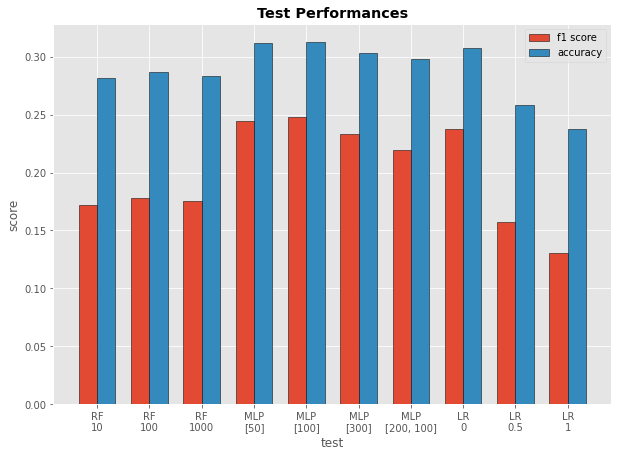

In [0]:
width = 0.35
plt.figure(figsize=(10, 7))
plt.style.use('ggplot')
plt.bar(test_num - width/2, f1_scores, width, edgecolor='black', label='f1 score')
plt.bar(test_num + width/2, acc_scores, width, edgecolor='black', label='accuracy')

plt.xlabel('test')
plt.ylabel('score')
plt.title('Test Performances', fontweight='bold')
plt.xticks(test_num, labels=test_labels)
plt.legend()

plt.show()

The model we will choose to proceed with is **MLP, with a single hidden layer of size 100**.

From the graph above, this model received the highest results among all tested models: F1 score of 0.248 and accuracy of 0.313.

*As seen in previous sections, the distribution of the labels is imbalanced. Thus, while experimenting, we tried to improve our models’ performance by incorporating the inverse probability weights (IPW) of the labels (based on their imperial distribution) during the training process. Unfortunately, this attempt proved to be unsuccessful, and therefore we chose not to incorporate it, nor display the results we received.

### Feature Selection

After finding the model and its architecture that we will use in the project, we would like to select the best subset of features (among the initial feature set) for it.

In order to find the optimal subset of features for our model, it is required to check all possible subsets of features. Unfortunately, this process is computationally unfeasible, as it is exponential in the total number of features (in our case 2^12).

Therefore, in order to overcome this obstacle, we will define an iterative greedy approach, as follows:

First, we will define a feature set that will be maintained throughout the process. The starting feature set will be defined as the set of all features that we extracted in previous sections. 

Then, we will iteratively try to remove features from that feature set. In each iteration, we will remove features from the current feature set, one by one, and check if it improves the model's performance (specifically, the F1 score). While iterating over the features, if removing some feature indeed improves our F1 score, we will permanently remove it from our feature set, and move on to the next iterations without it. In the next iteration, we will again try to remove each of the features in the current feature set, check whether it improves our results, and so on.

When an iteration ends without any improvements to the F1 score (in other words, removing any feature from the current feature set will lower the score), we return the current feature set.

The returned feature set will be the selected one.

In [0]:
def test_features(features, train_set, test_set):
    # prepare the train set for the model
    train_assembler = VectorAssembler(inputCols=train_set.select(features).columns, outputCol="features")
    train_set_vectorized = train_assembler.transform(train_set)

    # prepare the test set for the model
    test_assembler = VectorAssembler(inputCols=test_set.select(features).columns, outputCol="features")
    test_set_vectorized = test_assembler.transform(test_set)

    f1, acc = test_model("MLP", [100], train_set_vectorized, test_set_vectorized)
    return f1, acc

In [0]:
# remove label
all_features = train_set.columns[:-1]

In [0]:
cur_feature_set = all_features
best_f1, _ = test_features(all_features, train_set, test_set)

f1_improved_in_iter = True
iter_num = 0

while f1_improved_in_iter:
    f1_improved_in_iter = False
    saw_field = False

    iter_num += 1
    print(f"\n\n*------ Currently running iteration: {iter_num} ------*")
    print(f"Current feature set:\n{cur_feature_set}\n")
    print(f"F1 score for the currrent feature set: {best_f1:.5f}\n")

    for feature in cur_feature_set:
        feature_name = feature

        features_to_test = cur_feature_set.copy()

        if feature.startswith("field"):
            feature_name = "field_cs"

            if saw_field:
                continue
            
            saw_field = True

            # remove all 'field' columns
            for ftr in cur_feature_set:
                if ftr.startswith("field"):
                    features_to_test.remove(ftr)
            
        else:
            features_to_test.remove(feature)
        
        f1, _ = test_features(features_to_test, train_set, test_set)

        print(f"Removed feature {feature_name}, received F1 score: {f1:.5f}")

        if f1 > best_f1:
            best_f1 = f1
            cur_feature_set = features_to_test.copy()

            f1_improved_in_iter = True
            print(f"\nF1 score is improved, removing feature '{feature_name}' permanently...")
            break
    
    print("------------------------------------------------")


print(f"\n\nBest feature set:\n{cur_feature_set}\n")
print(f"Best F1 score received: {best_f1:.5f}")


      
*------ Currently running iteration: 1 ------*
Current feature set:
['recommendations_count', 'field-Creative and Artistic_cs', 'field-Management and Leadership_cs', 'field-Nonprofit and Social Services_cs', 'field-Customer Service and Sales_cs', 'field-Healthcare and Medical_cs', 'field-Legal and Law_cs', 'field-Education and Teaching_cs', 'field-Technology and Engineering_cs', 'field-Financial and Accounting_cs', 'field-Business and Administration_cs', 'about_embedding', 'num_degrees', 'highest_degree', 'edu_years', 'num_jobs', 'exp_years', 'num_certifications', 'num_languages', 'num_volunteers', 'num_courses']

F1 score for the currrent feature set: 0.25099

Removed feature recommendations_count, received F1 score: 0.23874
Removed feature field-Creative and Artistic_cs, received F1 score: 0.24695
Removed feature about_embedding, received F1 score: 0.20888
Removed feature num_degrees, received F1 score: 0.24060
Removed feature highest_degree, received F1 score: 0.24802
Remove

As we can see, the best feature subset received with our method is **the initial feature set**.

Thus, our final model will be MLP with a single hidden layer of size 100, using the initial set of features. 

## Model Evaluation

In the previous sections, we used 25% of the data to find our final model. Now that we have this model at hand, we would like to evaluate its performance using our entire dataset.

First, let us create the full dataset: 

In [0]:
full_dataset = get_dataset(users, bert_pipeline)

Now, let us create the full train and test sets using a 80%/20% split on the full dataset:

In [0]:
train_set, test_set = full_dataset.randomSplit([0.8, 0.2], seed=42)

train_assembler = VectorAssembler(inputCols=train_set.drop("label").columns, outputCol="features")
train_set_vectorized = train_assembler.transform(train_set).select("features", "label")

test_assembler = VectorAssembler(inputCols=test_set.drop("label").columns, outputCol="features")
test_set_vectorized = test_assembler.transform(test_set).select("features", "label")

Lastly, let us train our final model on the full train set, and get its predictions on the full test set:

In [0]:
# create the model
input_size = len(train_set_vectorized.select("features").limit(1).collect()[0][0])
output_size = 10

final_model = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label",
                                    layers=[input_size, 100, output_size],
                                    seed=42)

# train
final_model = final_model.fit(train_set_vectorized)

# test
test_preds = final_model.transform(test_set_vectorized)

Now that we have the model's predictions on the full test set, we will perform several analysis methods in order to evaluate it.

### General Metrics

Let us evaluate our final model using the general metrics of F1 score and accuracy:

In [0]:
# evaluate
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator_f1.evaluate(test_preds)

evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc = evaluator_acc.evaluate(test_preds)

print(f"------ Final Model Results ------")
print(f"F1 score on the full test set: {round(f1, 3)}")
print(f"Accuracy score on the full test set: {round(acc, 3)}")

------ Final Model Results ------
F1 score on the full test set: 0.235
Accuracy score on the full test set: 0.307


As we can see, unfortunately, the model's performance is a bit underwhelming. 

Moreover, both metrics results were slightly higher when using the sampled dataset. This result is surprising to us, since we would expect that training on more data would yield better results. However, let us be reminded that the smaller dataset was sampled, and therefore may not truly represent the full one.

### Classwise Analysis

Now, we will perform classwise analysis in order to evaluate our model's performance on each group.

In [0]:
predictions_and_labels = test_preds.select("prediction", "label").rdd
predictions_and_labels = predictions_and_labels.map(lambda x: (float(x[0]), float(x[1])))

# initialize the multiclass metrics object
metrics = MulticlassMetrics(predictions_and_labels)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


First, let us display the F1 score for each class:

In [0]:
group_names = ["Management and Leadership", "Healthcare and Medical", "Education and Teaching", "Business and Administration", "Legal and Law", "Technology and Engineering", "Creative and Artistic", "Financial and Accounting", "Customer Service and Sales", "Nonprofit and Social Services"]

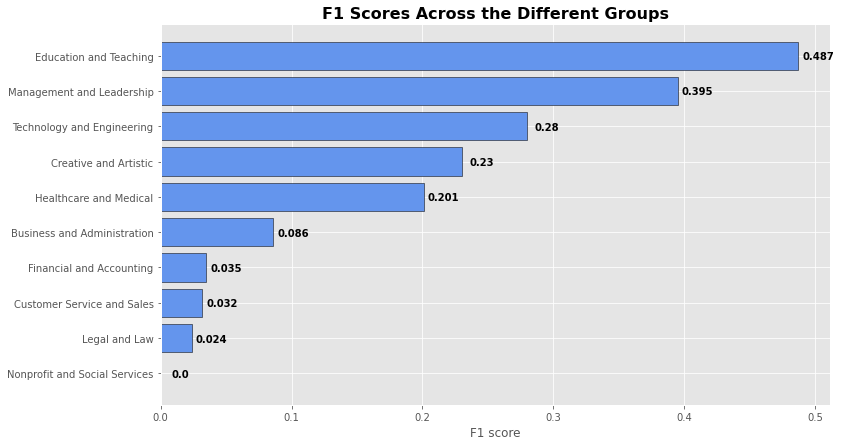

In [0]:
tup_lst = []
for i, group_name in enumerate(group_names):
    f1_score = metrics.fMeasure(float(i))
    tup_lst.append((group_name, f1_score)) 

tup_lst = sorted(tup_lst, key=lambda x: x[1])

sorted_groups = [x[0] for x in tup_lst]
sorted_f1_scores = [x[1] for x in tup_lst]

plt.figure(figsize=(12, 7))
plt.style.use('ggplot')
plt.barh(sorted_groups, sorted_f1_scores, color="cornflowerblue", linewidth=0.5, edgecolor="black")

for i in range(len(sorted_f1_scores)):
    plt.text(sorted_f1_scores[i] + 0.015, i-0.1, str(round(sorted_f1_scores[i], 3)), ha='center', fontweight="bold")

plt.title("F1 Scores Across the Different Groups", fontsize=16, fontweight="bold")
plt.xlabel("F1 score")

plt.show();

From the above we can see the following:

- Our model has quite an impressive predictive power on the 'Education and Teaching' and 'Management and Leadership' classes.

- Our model preforms at a mediocre level on the 'Technology and Engineering', 'Healthcare and Medical' and 'Creative and Artistic' classes.

- Our model performs quite poorly on the 'Business and Administration', 'Financial and Accounting' and 'Customer Service and Sales' classes.

- Our model performs extermely poorly on the 'Nonprofit and Social Services' and 'Legal and Law' classes with an F1 score of ~0.

Now, let us display below a confusion matrix of our final model's predictions on the test set:

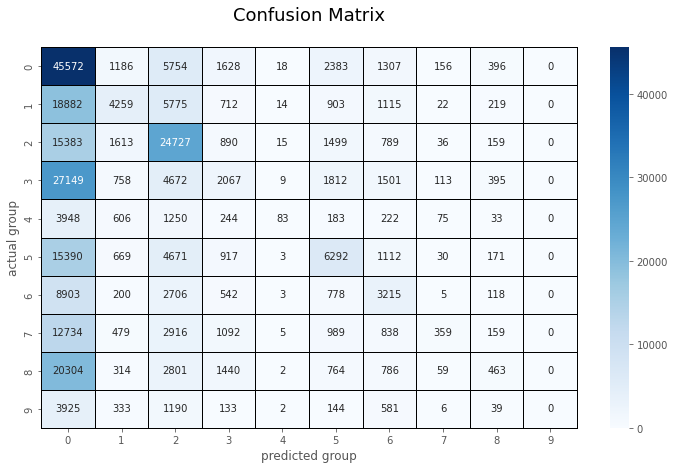

In [0]:
cm = metrics.confusionMatrix().toArray()

num_classes = 10
plt.figure(figsize=(12, 7))
sns.heatmap(cm, cmap="Blues", annot=True, linewidth=0.5, edgecolor="black", linecolor="black", fmt=".0f", clip_on=False)
plt.title("Confusion Matrix\n", fontsize=18)

plt.xlabel("predicted group")
plt.ylabel("actual group")

plt.xticks(np.arange(0.5, len(cm[0]), 1), range(num_classes))
plt.yticks(np.arange(0.5, len(cm), 1), range(num_classes))

plt.show();

For the sake of discussion, let us be reminded of the encoding of groups to numerical labels:

- Management and Leadership: 0
- Healthcare and Medical: 1
- Education and Teaching: 2
- Business and Administration: 3
- Legal and Law: 4
- Technology and Engineering: 5
- Creative and Artistic: 6
- Financial and Accounting: 7
- Customer Service and Sales: 8
- Nonprofit and Social Services: 9

Thus, as we can see, our model's most common errors are:

- Commonly misclassifying many different groups to be "Management and Leadership".

- Misclassifying "Business and Administration" as "Management and Leadership" quite often. This insight makes sense to us, as these groups require similar skills and qualities.

- Never classifying instances as "Nonprofit and Social Services", and rarely classifying instances as "Legal and Law". In our opinion, this result is not surprising, since these classes are extremely underrepresented in our data.

### Feature Importance

Let us be reminded that our final model is MLP, of which the predictions are hard to interpret. Still, we would like to evaluate its "way of thinking". In order to achieve that, we would like to assess the importance of each feature.

As we know, the Random Forest model is extremely interpretable, and thus, it is easy to extract each feature's importance from it. In order to utilize this property, we trained an RF model using our final feature subset as the features, and **our model's predictions as the true labels**. Thus, we are “forcing” it to perform similarly to our final model. This process should result in the RF model having similar decision boundaries. After the training process, we used the feature importances of the RF model as an estimation for the feature importances of our model.

In [0]:
# convert our final model's predictions into the labels that the RF model is trained on
feature_importance_dataset = test_preds.drop("label", "probability", "rawPrediction").withColumnRenamed("prediction", "label")

feature_importance_rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, seed=42)

feature_importance_rf = feature_importance_rf.fit(feature_importance_dataset)

In [0]:
feature_names = full_dataset.drop("label").columns

feature_names = [feature_names[0]] + ["field_cs"] + feature_names[11:]

feature_importances = list(feature_importance_rf.featureImportances)

feature_importances = [feature_importances[0]] + [sum(feature_importances[1:11])] + [sum(feature_importances[11:139])] + feature_importances[139:]

for f_name, f_importance in zip(feature_names, feature_importances):
    print(f"The feature importance of feature '{f_name}': {f_importance:.3f}")

The feature importance of feature 'recommendations_count': 0.002
The feature importance of feature 'field_cs': 0.204
The feature importance of feature 'about_embedding': 0.182
The feature importance of feature 'num_degrees': 0.090
The feature importance of feature 'highest_degree': 0.121
The feature importance of feature 'edu_years': 0.161
The feature importance of feature 'num_jobs': 0.150
The feature importance of feature 'exp_years': 0.082
The feature importance of feature 'num_certifications': 0.006
The feature importance of feature 'num_languages': 0.000
The feature importance of feature 'num_volunteers': 0.000
The feature importance of feature 'num_courses': 0.002


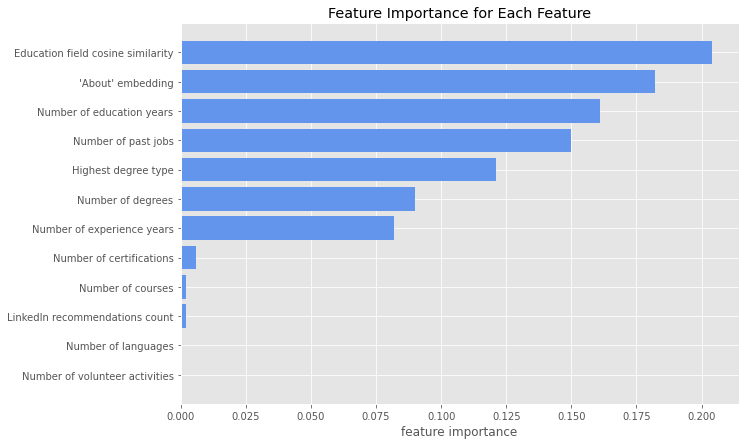

In [0]:
y_vals = ['Number of volunteer activities', 'Number of languages', 'LinkedIn recommendations count', 'Number of courses', 'Number of certifications', 'Number of experience years', 'Number of degrees', 'Highest degree type', 'Number of past jobs', 'Number of education years', "'About' embedding", 'Education field cosine similarity']

x_vals = [0.0, 0.0, 0.002, 0.002, 0.006, 0.082, 0.09, 0.121, 0.15, 0.161, 0.182, 0.204]

plt.figure(figsize=(10, 7))
plt.style.use('ggplot')
plt.barh(y_vals, x_vals, color="cornflowerblue")
plt.title("Feature Importance for Each Feature")
plt.xlabel("feature importance");


As we can see, the 'field_cs' feature proved to be the most important for our model. This result is not surprising to us since the field attribute is closely related to a person's career.

In addition, the second most important feature for our model is 'about_embedding'. This result is to be expected given the fact that the 'about' section is a concise description of the person's background.

Furthermore, it seems that the least important features for our model are 'num_languages' and 'num_volunteers', with feature importance of zero for both. However, notice that this is only an estimation, and our final model indeed finds these feature somewhat important (as seen in the Feature Selection section).

## Finding the Most Common Job Titles in Each Group

## (for Data Scraping)

We would like to provide a salary estimation for each group (career path). 

In order to gain this information, first, for each group, we want to obtain data regarding different salary listings of the most frequent job titles under it. 

Let us display the top 5 most common job titles for each group:

In [0]:
groups = ['Management and Leadership', 'Healthcare and Medical', 'Education and Teaching', 'Business and Administration', 'Legal and Law', 'Technology and Engineering', 'Creative and Artistic', 'Financial and Accounting', 'Customer Service and Sales', 'Nonprofit and Social Services']

In [0]:
for group in groups:
    group_df = users.filter(F.col("group") == group).groupBy(F.col("job_title")).count().sort(F.desc(F.col("count")))
    group_top5_df = group_df.limit(5)

    print(f"Top 5 most frequent job titles ----- {group}")
    group_top5_lst = group_top5_df.collect()
    group_top5_lst = [(row["job_title"], row["count"]) for row in group_top5_lst]

    for jt, cnt in group_top5_lst:
        print(f"{jt}: {cnt}")
    
    print()

Top 5 most frequent job titles ----- Management and Leadership
owner: 42564
president: 21928
manager: 15124
project manager: 9719
ceo: 9170

Top 5 most frequent job titles ----- Healthcare and Medical
registered nurse: 9829
rn: 8035
hospital & health care professional: 4998
physician: 2487
medical assistant: 2316

Top 5 most frequent job titles ----- Education and Teaching
student: 105345
teacher: 23715
principal: 4194
professor: 3355
educator: 2682

Top 5 most frequent job titles ----- Business and Administration
office manager: 9814
administrative assistant: 9196
realtor: 8683
executive assistant: 3944
account executive: 3497

Top 5 most frequent job titles ----- Legal and Law
attorney: 6292
paralegal: 2740
legal assistant: 1973
j.d. candidate: 1000
legal secretary: 785

Top 5 most frequent job titles ----- Technology and Engineering
software engineer: 5766
engineer: 3307
senior software engineer: 1933
information technology and services professional: 1928
electrician: 1757

Top 5 mo

Since we cannot import the scraping libraries to Databricks, we ran the corresponding code on Google Colab.

## User Interface

In this section, we will create a simple user interface which demonstrates our system's capabilities.

In [0]:
EMPTY = ""

def get_value(value, casting, empty_value):
  
    if value == EMPTY:
      value = empty_value

    return casting(value)

def encode_highest_degree(highest_degree):
  highest_degree = str.lower(highest_degree)

  if highest_degree == "non-academic":
    highest_degree_numerical = 1

  elif highest_degree == "bachelor's":
    highest_degree_numerical = 2

  elif highest_degree == "master's":
    highest_degree_numerical = 3

  elif highest_degree == "phd":
    highest_degree_numerical = 4

  else:
    highest_degree_numerical = 0

  return highest_degree_numerical

def get_user_info():
    user_info_dict = {}

    about_input = input("Please write a short section about yourself (from a career standpoint): ")
    user_info_dict["about"] = get_value(about_input, casting=str, empty_value=None)
    print()

    print("Now, please fill in some information regarding your education.")
    num_degrees_input = input("Number of academic achievements (integer): ")
    user_info_dict["num_degrees"] = get_value(num_degrees_input, casting=int, empty_value=0)
    print()

    # if user has no degrees, auto-fill the rest of the education features
    if user_info_dict["num_degrees"] == 0:
        user_info_dict["highest_degree"] = 0
        user_info_dict["edu_years"] = 0
        user_info_dict["field"] = []
    
    else:
        highest_degree_input = input("Highest degree type (one of the following: Non-academic/Bachelor's/Master's/PhD): ")
        user_info_dict["highest_degree"] = encode_highest_degree(highest_degree_input)
        print()

        edu_years_input = input("Accumulated years of education (integer): ")
        user_info_dict["edu_years"] = get_value(edu_years_input, casting=int, empty_value=0)
        print()

        fields_str = input("Titles of each of your academic achievements (separated by commas): ")

        if fields_str == EMPTY:
          user_info_dict["field"] = []
        
        else:
          fields_lst = fields_str.split(",")
          user_info_dict["field"] = fields_lst
        print()


    print("Now, please fill in some information regarding your job experience.")
    num_jobs_input = input("Number of past jobs (integer): ")
    user_info_dict["num_jobs"] = get_value(num_jobs_input, casting=int, empty_value=0)
    print()

    # if user has no past jobs, auto-fill the rest of the experience features
    if user_info_dict["num_jobs"] == 0:
        user_info_dict["exp_years"] = 0.0
    
    else:
        exp_years_input = input("Accumulated years of experience (number): ")
        user_info_dict["exp_years"] = get_value(exp_years_input, casting=float, empty_value=0)
        print()


    print("Now, please fill in some miscellaneous information.")
    num_certifications_input = input("Number of certifications (integer): ")
    user_info_dict["num_certifications"] = get_value(num_certifications_input, casting=int, empty_value=0)
    print()

    num_languages_input = input("Number of spoken languages (integer): ")
    user_info_dict["num_languages"] = get_value(num_languages_input, casting=int, empty_value=0)
    print()

    num_volunteers_input = input("Number of volunteer activities (integer): ")
    user_info_dict["num_volunteers"] = get_value(num_volunteers_input, casting=int, empty_value=0)
    print()

    num_courses_input = input("Number of courses taken (integer): ")
    user_info_dict["num_courses"] = get_value(num_courses_input, casting=int, empty_value=0)
    print()

    recommendations_count_input = input("Number of recommendations received on LinkedIn (integer): ")
    user_info_dict["recommendations_count"] = get_value(recommendations_count_input, casting=int, empty_value=0)
    print()

    return user_info_dict

def process_user_info(user_info_dict, pipeline, group_name_embeddings, cols_order):

  items = list(user_info_dict.items())
  # sort to make the feature names (keys) in the same order as the one in the schema
  items.sort(key=lambda x: x[0])

  # define the user df schema
  schema = StructType([
    StructField("about", StringType(), True),
    StructField("edu_years", IntegerType(), True),
    StructField("exp_years", FloatType(), True),
    StructField("field", ArrayType(StringType()), True),
    StructField("highest_degree", IntegerType(), True),
    StructField("num_certifications", IntegerType(), True),
    StructField("num_courses", IntegerType(), True),
    StructField("num_degrees", IntegerType(), True),
    StructField("num_jobs", IntegerType(), True),
    StructField("num_languages", IntegerType(), True),
    StructField("num_volunteers", IntegerType(), True),
    StructField("recommendations_count", IntegerType(), True)
  ])

  # create the sinle row of the user df
  row = [tuple([value for (_, value) in items])]

  # create the user df
  user_df = spark.createDataFrame(row, schema)

  # calcualte the user's 'field_cs' features

  # explode the 'field' column (array)
  user_df = user_df.withColumn("field", F.explode("field"))

  # the array was not empty
  if user_df.dropna().count() > 0:
    # calculate the 'field_cs' features values
    user_df = get_column_cosine_similarity(user_df, pipeline, "field", group_name_embeddings)

  # the array was empty
  else:
    # define the 'field_cs' features values to zeros
    for (group_name, _) in group_names_embeddings:
      user_df.withColumn(f"field-{group_name}_cs", F.lit(0))
    
    user_df = user_df.drop("field")

  # embed the user's 'about' value
  user_df = embed_column(user_df, pipeline, "about")
  user_df = user_df.withColumn('about_embedding', array_to_vector_s(F.col('about_embedding')))

  return user_df.select(cols_order)

def get_group_prediction(user_df, final_model, label_to_group_dict):
    assembler = VectorAssembler(inputCols=user_df.columns, outputCol="features")
    user_vectorized = assembler.transform(user_df)

    label_pred = final_model.transform(user_vectorized).select("prediction").collect()[0][0]
    group_pred = label_to_group_dict[int(label_pred)]

    return group_pred

Let us create variables that will be used in our final user interface function.

Note that these variables could have been parameters of the function. However, we chose to exclude them in order to "hide" their existence from the user. In other words, we would like the user interface function to simulate the user's experience as closely as possible.

In [0]:
def get_estimated_salary_dict(file_name, index_col):
    path = f"/Workspace/Users/ariel.cohen@campus.technion.ac.il/{file_name}"
    estimated_salaries_df = pd.read_csv(path, index_col=index_col)
    estimated_salaries_dict = estimated_salaries_df.to_dict()["estimated_salary"]

    return estimated_salaries_dict

In [0]:
GROUP_SALARY_DICT = get_estimated_salary_dict("estimated_group_salaries.csv", "group")
JOB_SALARY_DICT = get_estimated_salary_dict("estimated_job_salaries.csv", "job_title")


RECOMMENDED_JOBS_PER_GROUP = {
    "Management and Leadership": ["Manager", "Project Manager", "CEO"],
    "Healthcare and Medical": ["Registered Nurse", "Hospital and Health Care Professional", "Physician"],
    "Education and Teaching": ["Teacher", "Principal", "Professor"],
    "Business and Administration": ["Office_manager", "Administrative_assistant", "Realtor"],
    "Legal and Law": ["Attorney", "Paralegal", "Legal Assistant"],
    "Technology and Engineering": ["Software Engineer", "Information Technology and Services Professional", "Electrician"],
    "Creative and Artistic": ["Graphic Designer", "Photographer", "Content Writer"],
    "Financial and Accounting": ["Accountant", "Controller", "Bookkeeper"],
    "Customer Service and Sales": ["Account Manager", "Sales Manager", "Sales Associate"],
    "Nonprofit and Social Services": ["Pastor", "Social Worker", "Program Coordinator"]
}

COLS_ORDER = ['recommendations_count', 'field-Creative and Artistic_cs', 'field-Management and Leadership_cs',
              'field-Nonprofit and Social Services_cs', 'field-Customer Service and Sales_cs',
              'field-Healthcare and Medical_cs', 'field-Legal and Law_cs', 'field-Education and Teaching_cs',
              'field-Technology and Engineering_cs', 'field-Financial and Accounting_cs',
              'field-Business and Administration_cs', 'about_embedding', 'num_degrees', 'highest_degree',
              'edu_years', 'num_jobs', 'exp_years', 'num_certifications', 'num_languages', 'num_volunteers','num_courses']

LABEL_TO_GROUP_DICT = ["Management and Leadership", "Healthcare and Medical", "Education and Teaching", "Business and Administration", "Legal and Law", "Technology and Engineering", "Creative and Artistic", "Financial and Accounting", "Customer Service and Sales", "Nonprofit and Social Services"]

BERT_PIPELINE = bert_pipeline
GROUP_NAME_EMBEDDINGS = get_group_embeddings(users, BERT_PIPELINE)
FINAL_MODEL = final_model

In [0]:
def recommend_career_path():
    print("Welcome To Our Career Path Recommender!")
    print("Let's get started! Please tell us about yourself below.\n")

    user_info_dict = get_user_info()

    print("Finding the best career path for you...\n\n")

    user_df = process_user_info(user_info_dict, BERT_PIPELINE, GROUP_NAME_EMBEDDINGS, COLS_ORDER)
    group_pred = get_group_prediction(user_df, FINAL_MODEL, LABEL_TO_GROUP_DICT)

    print(f"*----- Your Recommended Career Path is: {group_pred}! -----*")
    print(f"The estimated salary for this career path is: {GROUP_SALARY_DICT[group_pred]}K$\n")
    print("Here are some suggestions for popular jobs in this career path, along with their estimated salary:")

    suggested_jobs = RECOMMENDED_JOBS_PER_GROUP[group_pred]
    for num, suggested_job in enumerate(suggested_jobs, start=1):
        print(f"{num}. {suggested_job} ----- {JOB_SALARY_DICT[suggested_job]}K$")
    
    print("\n\n*All of the estimated salary information is derived from the Glassdoor website, and is presented in annual income format.")
    print("\nGood luck in your career journey! :)")

The function below is the only part that the user will see. 

Run the simulation by running the code block.

In [0]:
# Run this code block in otder to run the simulation!
recommend_career_path()

Welcome To Our Career Path Recommender!
Let's get started! Please tell us about yourself below.



Please write a short section about yourself (from a career standpoint):  I specialize in data science and coding. I can program in Python and Java.


Now, please fill in some information regarding your education.


Number of academic achievements (integer):  1

Highest degree type (one of the following: Non-academic/Bachelor's/Master's/PhD):  Bachelor's

Accumulated years of education (integer):  4

Titles of each of your academic achievements (separated by commas):  Data Science Degree


Now, please fill in some information regarding your job experience.


Number of past jobs (integer):  1

Accumulated years of experience (number):  1


Now, please fill in some miscellaneous information.


Number of certifications (integer):  1

Number of spoken languages (integer):  2

Number of volunteer activities (integer):  0

Number of courses taken (integer):  2

Number of recommendations received on LinkedIn (integer):  0


Finding the best career path for you...


*----- Your Recommended Career Path is: Technology and Engineering! -----*
The estimated salary for this career path is: 81K$

Here are some suggestions for popular jobs in this career path, along with their estimated salary:
1. Software Engineer ----- 99K$
2. Information Technology and Services Professional ----- 66K$
3. Electrician ----- 77K$


*All of the estimated salary information is derived from the Glassdoor website, and is presented in annual income format.

Good luck in your career journey! :)
